In [2]:
%matplotlib inline
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:95% !important; }</style>"))

#modules to find path of all sessions
import glob
import os
import numpy as np
import pickle
import platform
import math
from IPython.display import clear_output, display, HTML
from matplotlib.patches import Rectangle
from matplotlib import collections  as mc
import matplotlib.gridspec as gridspec
from scipy.ndimage.filters import gaussian_filter as smooth
import matplotlib
from __future__ import print_function
np.set_printoptions(precision=3, suppress=True)
import statsmodels.formula.api as smf
import matplotlib.pyplot as plt
from sklearn import metrics
from sklearn.cluster import KMeans


import warnings
warnings.filterwarnings('ignore')

### you might need to change the line below if you want to regenerate the figure on a differente computer 
### Below we will run some preprocessing notebooks. In our case, our preprocessing notebooks are located in 
### a folder ("load_preprocess_mouse") which is at the same level that the folder that contain the notebooks 
### that generate the figures (for instance this one)


notebookPath=os.path.dirname(os.path.realpath("__file__"))
pathToProcessingNotebooks=os.path.join(os.path.split(notebookPath)[0],"load_preprocess_mouse")
os.chdir(pathToProcessingNotebooks)   
%run loadMouse_documentation.ipynb
%run loadRawSpike_documentation.ipynb
%run plotMouse_Behavior.ipynb

#######

def has_tag(root, animal, session, tagList):
    """ Test if the session has at least one of the tag in tagList
    tag = empty file with a specific name, in a session folder
    """
    fullPath = os.path.join(root, animal, "Experiments", session)
    fileList = os.listdir(fullPath)
    for tag in tagList:
        if tag in fileList:
            return True
    return False

def cm2inch(value):
    return value/2.54
    

#Those parameters are overwritten if there is a .behav_param file
paramCarola={
    "distanceToRun":100,
    "maxTrialDuration": 60,
    "valveONTime":50,
    "minInterTrialDuration":15,
    "immobilityDuration":2,
    #to read .eeg (put None to not read .eeg)
    "nChannelElectro":32, #32
    "channel_opto": -6, #not used
    "channel_lickBreak":-5,
    "channel_reward": -4, #not used currently
    "channel_sound": -3, #not used
    "channel_trialON": -2,
    "channel_beamBreak": -1,
}    


#### root is the path to the folder where the data (MOUXXX, MOUXXY, ....ALLMOU_Analysis) are located
### you might need to change the line below depending on your computer orgnization



if platform.system()=='Linux':
    root="/data"
else:
    root="/Users/davidrobbe/Documents/Data/"
    
    
# Where to Save Files

saveFigurePath=os.path.join(root,"ALLMOU_Analysis","FigForMS")
    
print("path to data is %s"%root)
print("")
print("importing done")

ERROR: File `'plotMouse_SpikingActvity.ipynb.py'` not found.


path to data is /data

importing done


In [3]:
%run plotMouse_SpikingActivity.ipynb

## Part I: For all the cells accross good sessions compute meanfiringrate during runs and find significant modulation portion
## <span style="color:red">Take ~ 10 min to run!</span> No need to rerun it each time: output are saved in pickle files

List of animal to loop through: ['MOU001', 'MOU002', 'MOU004', 'MOU006', 'MOU007', 'MOU013', 'MOU015', 'MOU016', 'MOU017', 'MOU018', 'MOU019', 'MOU024', 'MOU025', 'MOU026', 'MOU027', 'MOU028', 'MOU029', 'MOU030', 'MOU031', 'MOU032', 'MOU033', 'MOU034', 'MOU035', 'MOU037', 'MOU045', 'MOU046', 'MOU050', 'MOU051', 'MOU052', 'MOU061', 'MOU063', 'MOU064', 'MOU069', 'MOU070', 'MOU071', 'MOU073', 'MOU074', 'MOU075', 'MOU079', 'MOU087', 'MOU091', 'MOU093', 'MOU094', 'MOU098', 'MOU100', 'MOU101', 'MOU102', 'MOU118', 'MOU119', 'MOU120', 'MOU121', 'MOU147', 'MOU150', 'MOU161', 'MOU167', 'MOU169']
Tag list: ['GoodPerfo']
Animal MOU001
1 out of 56
**********
Animal MOU002
2 out of 56
**********
Animal MOU004
3 out of 56
**********
Animal MOU006
4 out of 56
**********
Animal MOU007
5 out of 56
**********
Animal MOU013
6 out of 56
**********
Animal MOU015
7 out of 56
**********
Animal MOU016
8 out of 56
**********
Animal MOU017
9 out of 56
**********
Animal MOU018
10 out of 56
**********
Animal MOU01

KeyboardInterrupt: 

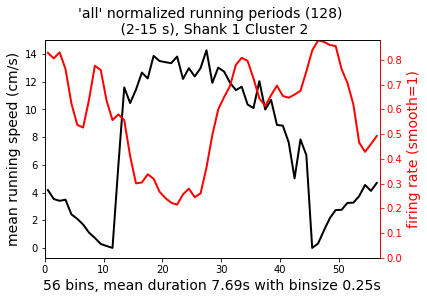

In [4]:
animalList = [os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]

#Whether to read the existing pickle files (redo=False) or to reload from raw text files (redo=True)
redo = False
###############################
redo = False
###############################
#Wheter to run some batch on electrophy data
runElectrophyBatch=True
###############################
runElectrophyBatch=True
###############################
#list of tags (tag = empty file in the session folder with a specific name)
#leave empty for no tag
tagList = ["GoodPerfo"]
###############################

###############################

#---------------------------------------------------------------------------
print("List of animal to loop through: %s" % animalList)
print("Tag list: %s" % tagList)

#loop on animal
animalindex=1
for animal in animalList:
    print("Animal %s"%animal)
    print("%s out of %s" %(animalindex,len(animalList)))
    print("**********")
    animalindex += 1
    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    nbSession=len(sessionList)
    
    
    
    #loop through sessions
    for index, session in enumerate(sessionList):
        
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
        
        #print("Session %s/%s: %s"%(index+1,nbSession,session))
        #load data for this session (add redoPreprocess=True to overwrite preprocess)
        
        sessionData=Data(root, animal, session, param=paramCarola, redoPreprocess=redo)
            

        
        if runElectrophyBatch:


            print("Session %s is beeing analyzed with  GetAllSignificantModulation function"%session)
            GetAllSignificantModulation(sessionData,redo=True,saveAsPickle=True,excludeDrift=True,behaviorType=["Runs","all"])


clear_output()
print("Done")


## Part II: Calculate the mean duration of the run epochs for all the units accross sessions to normalize run duration accross session


In [4]:
behaviorType=["Runs","all"]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
#list of all animals
animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]


### loop throught the session to find the length of average firing rate for the different sessions


averageRunDurationAccrossAllUnits=[]




#loop on animal
for animal in animalList:

    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)   

    #loop through sessions and load pickle file
    for index,session in enumerate(sessionList):


        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                           
        
        
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        firingRatesModulation=pickle.load(open(picklePath,"rb"))
        
        
        for shank in firingRatesModulation["MeanFiringRateZscored"]:
            for cluster in firingRatesModulation["MeanFiringRateZscored"][shank]:
                if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                    averageRunDurationAccrossAllUnits.append(len(firingRatesModulation["insideBehaviorIndexes"][shank][cluster]))
                    
nSideBin=firingRatesModulation["insideBehaviorIndexes"][shank][cluster][0]
medianAverageRunDurationAccrossAllUnits=np.median(averageRunDurationAccrossAllUnits)
print("number of units %s" %(len(averageRunDurationAccrossAllUnits)))
print("median duration of runs %s" %medianAverageRunDurationAccrossAllUnits)


number of units 146
median duration of runs 28.0


## Part III:  ReNormalize Firing rate in the time domain (versus median run duration)

### Can select units that have been determined to have a postive or negative modulation during run using the function GetModulatedPortionsDuringRun
(This code is Modified from an orginal version below.june 2016)

In [5]:
def normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes):
    
    meanFiringRateInRun=thisFiringRateModulation[insideRunBins]
    runIndexes=range(len(meanFiringRateInRun))
    runIndexesInterp=np.arange(0,float(runIndexes[-1])+float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1),float(runIndexes[-1])/float(medianAverageRunDurationAccrossAllUnits-1))
    if len(runIndexesInterp)>medianAverageRunDurationAccrossAllUnits:
        runIndexesInterp=np.asarray([x for x in runIndexesInterp if x <= float(runIndexes[-1])])

    # do the itnerpolation
    meanFiringRateInRunNorm=np.interp(runIndexesInterp,runIndexes,meanFiringRateInRun)
    # reconcatenate the borders
    normFiringRateInRun=np.concatenate([thisFiringRateModulation[0:insideRunBins[0]],meanFiringRateInRunNorm,thisFiringRateModulation[insideRunBins[-1]+1:]],axis=0)

    
    # find the significant modulation on time normalized data
    allIndexes=list(range(len(thisFiringRateModulation)));
    allIndexesInterpt=np.concatenate([allIndexes[:insideRunBins[0]],runIndexesInterp+insideRunBins[0],allIndexes[-insideRunBins[0]:]],axis=0)
    
    #Get the border of the modulation
    borders=contiguous_regions(np.asarray([X in signifiantModulationIndexes for X in allIndexes])).tolist()
    interpolatedSignificantIndexes=[]
    for startstop in borders:
        interpolatedSignificantIndexes.append([index for index,value in enumerate(allIndexesInterpt) if (value>=startstop[0] and value<=startstop[1])])
    
    return normFiringRateInRun,interpolatedSignificantIndexes
    
    
    
    

# loop across data to normalize length of mean firing rate across session
# keep cells that have a modulation sign according to TargetString

#animalList=[os.path.basename(path) for path in sorted(glob.glob(root+"/MOU*"))]
tagList = ["GoodPerfo"]
targetStrings=["positive","negative"]
allFiringRates=[]
nberOfPositivelyModulatedCells=0
nberOfNegativelyModulatedCells=0
for animal in animalList:


    #Get the list of all session
    sessionList=[os.path.basename(expPath) for expPath in glob.glob(root+"/"+animal+"/Experiments/MOU*")]
    sessionList=sorted(sessionList)
    
  

    #loop through sessions
    for index,session in enumerate(sessionList):
        #if tag list is not emtpy
        if tagList:
            #check if the session has one of the tag
            if not has_tag(root, animal, session, tagList):
                continue
                
        analysisPath=os.path.join(root,animal,"Experiments",session,"Analysis")
        picklePath=os.path.join(analysisPath,"ModulationDuring" + behaviorType[1].replace(" ","") + behaviorType[0] + ".p")
        if os.path.exists(picklePath):
            #print(picklePath)
            firingRatesModulation=pickle.load(open(picklePath,"rb"))
            
            for shank in firingRatesModulation["MeanFiringRate"]:
                for cluster in firingRatesModulation["MeanFiringRate"][shank]:
                    if firingRatesModulation["BiggestModulationSign"][shank][cluster] in targetStrings:
                        insideRunBins=firingRatesModulation['insideBehaviorIndexes'][shank][cluster]
                        thisFiringRateModulation=firingRatesModulation["MeanFiringRate"][shank][cluster]
                        signifiantModulationIndexes=firingRatesModulation["AllSignificantModulationIndexInBehaviorSameSignThanBiggest"][shank][cluster]
                        normFiringRateInRun,interpolatedSignificantIndexes=normalizeFiringRateInTime(thisFiringRateModulation,insideRunBins,medianAverageRunDurationAccrossAllUnits,signifiantModulationIndexes)
                           
                        
                        #find max or min and append main variables in a big list
                        if firingRatesModulation["BiggestModulationSign"][shank][cluster]=='positive':
                            strongestModulationIndex=np.argmax(normFiringRateInRun)
                            nberOfPositivelyModulatedCells+=1

                        elif firingRatesModulation["BiggestModulationSign"][shank][cluster]=='negative':
                            strongestModulationIndex=np.argmin(normFiringRateInRun)
                            nberOfNegativelyModulatedCells+=1
                            
                        allFiringRates.append([strongestModulationIndex,normFiringRateInRun,interpolatedSignificantIndexes,session,shank,cluster,firingRatesModulation["BiggestModulationSign"][shank][cluster]])

firingRatesAs2DArray=np.asarray([item[1] for item in allFiringRates])
normFiringRatesAs2DArray=np.asarray([item[1]/max(item[1]) for item in allFiringRates])

# generate an array with just the significative positive modulation

allFiringRatesPositiveModulation=[firingRate for firingRate in allFiringRates if firingRate[-1]=='positive']
timeSortedFiringRatesPositiveModulation=sorted(allFiringRatesPositiveModulation, key=lambda firingdata: firingdata[0])
#timeSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in timeSortedFiringRatesPositiveModulation])
nonSortedFiringRatesAs2DArrayPositiveModulation=np.asarray([item[1] for item in allFiringRatesPositiveModulation])

In [6]:
normFiringRatesAs2DArray.shape

(146, 52)

In [7]:
def plot_distribution(rawdata,maxminstep,xyLabels=["N","Bins"]):   
    plt.hist(rawdata,np.arange(maxminstep[0],maxminstep[1]+maxminstep[2],maxminstep[2]),width=maxminstep[2]*0.9,color='k',linewidth=0)
    ax = plt.gca()
    #ax.set_xlim(maxminstep[:2])
    ax.set_xlim(maxminstep[0]-maxminstep[2],maxminstep[1]+maxminstep[2])
    ax.set_xlabel(xyLabels[1],fontsize=12,labelpad=0)
    ax.set_ylabel(xyLabels[0],fontsize=12,labelpad=0)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_xaxis().set_tick_params(direction='out')
    return ax

# Functions for PCA, polynome fit, classification
## this part was developped by Wahiba Taouali with correction of David

In [8]:
def normalize(x):
    return (x-np.min(x))/(np.max(x)-np.min(x))
#-------------------------------------------------
def plot_principal_components(tuningDict,nc,colors):
    '''
    tuningDict = dict of normalized mean firing rates
    nc = number of component to consider in PCA
    '''
    q = tuningDict
    nbins = len(q[0])
    from sklearn.decomposition.pca import PCA
    q=np.array(list(q.values()))
    for i in range(len(q)):
        q[i,:]=normalize(q[i,:])
    pca1 = PCA(n_components=nc)
    pca1.fit(q)
    print("n=2, explained variance: ",np.sum(pca1.explained_variance_ratio_)) 
    for i in range(nc):
        v=pca1.components_[i]
        plt.plot(v,colors[i], label="c "+np.str(i+1))

    #plt.plot(v2,"g--")
    ax = plt.gca()
    ax.set_xticks([0,nbins-1],["Beg","End"])
    ax.set_xlim(0,nbins-1)
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Norm. firing rate",fontsize=12,labelpad=0)
    ax.set_yticklabels([""])
    #plt.legend(loc="best",fontsize=8)
    #plt.plot(v2,"gray")
    #plt.yticks(np.arange(-0.3,0.4,0.1))
    print(len(v))
    return pca1
#-----------------------------------------------------------
def quadraticFit_stats(tuning_clu):
    nbins=len(tuning_clu)
    xdata = np.arange(nbins)
    #As an added benefit centering the x variable reduces the correlation between the linear and quadratic terms.
    #The correlation between x and x2 is 0.975 while the correlation between c and c2 is 0.000.==>
    xdata=xdata-np.mean(xdata)
    ydata=normalize(tuning_clu)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    c = model.params["Intercept"]
    return [a,b,pa<=0.05,pb<=0.05,c]
#--------------------------------------------------------------
def test_quadraticVslinear(a,b,c,pa,pb,x):
        y=a*x*x+b*x+c
        if pa and (not pb):
            if a>0 :#and np.abs(b/(-2*a))<1:
                    test="QuadraticConvexe"
            else:
                    test="QuadraticConcave"
        #elif  pb and (not pa):
        #    if b>0:
        #       test="Increasing"
        #    else:
        #        test="Decreasing"
        elif pb:#elif pb and pa:      
            if a>0:
                if y[0]<y[-1]:
                    test="QuadraticConvexeUp"
                else:
                    test="QuadraticConvexeDown"
            else:
                if y[0]>y[-1]:
                    test="QuadraticConcaveDown"
                else:
                    test="QuadraticConcaveUp"
        else:
            test="none"
        return test,y
#---------------------------------------------------
def classify_cells(clu_quadraticFit,xdata):
    #increasing =[]
    #decreasing =[]
    onset=[]
    offset=[]
    negOnset=[]
    negOffset=[]
    duration=[]
    onoff=[]
    none=[]
    for c in clu_quadraticFit:
        a,b,pa,pb,intercept=clu_quadraticFit[c]
        test,y=test_quadraticVslinear(a,b,intercept,pa,pb,xdata)
        if test=="QuadraticConcave":duration=np.append(duration,c)
        elif test=="QuadraticConcaveUp":negOffset=np.append(negOffset,c)
        elif test=="QuadraticConvexeUp":offset=np.append(offset,c) 
        elif test=="QuadraticConcaveDown":negOnset=np.append(negOnset,c) 
        elif test=="QuadraticConvexeDown":onset=np.append(onset,c)
        elif test=="QuadraticConvexe":onoff=np.append(onoff,c)
        else:none=np.append(none,c)
    #return onset,negOffset,offset,negOnset,onoff,duration,none
    return onoff,onset,negOnset,duration,negOffset,offset,none

def FindCellIndexInGroups(CellIndex,Groups):
    for index,CellIDs in enumerate(Groups):
        if CellIndex in CellIDs:
            return(index)
        
def plot_figureClasses(X,clu_quadraticFit_WT,xdata,nSideBin):
    from matplotlib.patches import Rectangle
   
    plt.imshow(X,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    ax = plt.gca()
    ax.tick_params(axis='both',which='major',width=2)
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    #ax.spines['bottom'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.set_ticks_position('none')
    ax.set_xticks([nSideBin,X.shape[1]/2,X.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='in',pad=1)
    ax.get_yaxis().set_tick_params(direction='in',pad=1)
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=3,alpha=0.7)
    ax.axvline( X.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=3,alpha=0.7)
    
    
    ax.set_xlabel("Run phase",fontsize=12,labelpad=1)
    ax.set_xticklabels(["start","","stop"])
    ax.set_yticks(np.arange(0,len(clu_quadraticFit_WT),20))
    ax.set_ylabel('Neurons + (sorted)',fontsize=12,labelpad=-5)
    names=["On/off","Onset(+)","Onset(-)","Duration",
           "Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    s0=0
    s1=0
    #plt.plot([53,55],[s0,s0],"k")
    cpt=0
    for i in classify_cells(clu_quadraticFit_WT,xdata):
        s0=s1
        s1+=(len(i))
        pad=-1
        colorbarsize=2
        plt.plot([X.shape[1]+pad,X.shape[1]+pad],[s0,s1],"w")
        ax.add_patch(Rectangle((X.shape[1]+pad, s0), colorbarsize, s1-s0, facecolor=colors[cpt]))
        plt.plot([X.shape[1]+pad,X.shape[1]+pad+colorbarsize],[s1,s1],"w")
        plt.text(X.shape[1]+pad+colorbarsize+0.5, s0+(s1-s0)/4., names[cpt], ha='left', va='bottom', rotation=30)
        cpt+=1
    ax.set_ylim(0,s1)
    ax.set_xlabel("Run phase")
    clear_output()
#---------------------------------------------------------------------------------
def illustrate_classes(tuningWithoutBorder,tuningWithBorders,nSideBin,ind,Groups,xdata,plotcellindex=False):
    ydata =tuningWithoutBorder[ind]
    ydatatoplot=normalize(tuningWithBorders[ind])
    n=len(ydata)
    xdata=xdata-np.mean(xdata)
    ydata=normalize(ydata)
    d={'x':xdata,"y":ydata}
    model = smf.ols(formula = 'y ~ np.power(x,2)+x',data=d).fit()
    b,a,pb,pa=model.params["x"],model.params['np.power(x, 2)'],model.pvalues["x"],model.pvalues['np.power(x, 2)']
    #print("b=%s,a=%s,pb=%s,pa=%s" %(b,a,pb,pa))
    c = model.params["Intercept"]
    ax=plt.gca()
    ax.set_xlabel("Run phase",fontsize=12)
    ax.set_ylabel("Normalized \n firing rate",fontsize=12)
    xaxis=np.arange(nSideBin,nSideBin+len(ydata))
    #plt.plot(xaxis,model.predict(),"c",lw=4)
    #ax.set_xticks([nSideBin,nSideBin+len(ydata)],["start","end"])
    ax.set_xticks([nSideBin,nSideBin+len(ydata)])
    ax.set_xticklabels(["start","stop"])
    #plt.xlim(0,n-1)
    ax.set_ylim(0,1.1)
    #ax.set_yticks([0,1],["min","max"])
    ax.spines['top'].set_color("none")
    ax.spines['right'].set_color("none")
    ax.yaxis.set_ticks_position('left')
    ax.xaxis.set_ticks_position('bottom')
    ax.get_yaxis().set_tick_params(direction='in')
    ax.get_xaxis().set_tick_params(direction='in',pad=1)
    
    #plt.fill_between(np.arange(len(ydatatoplot)),np.zeros(len(ydatatoplot)),ydatatoplot,color=colorfill)
    ax.axvspan(nSideBin, nSideBin+len(ydata), facecolor="orange",edgecolor="none",alpha=0.5)
    ax.plot(ydatatoplot,color='red',linewidth=2,alpha=0.5)
    
    names=["On/off","Onset(+)","Onset(-)","Duration","Offset(-)","Offset(+)","Other"]
    colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
    groupIndex=FindCellIndexInGroups(ind,Groups)
    ax.plot(xaxis,model.predict(),color=colors[groupIndex],lw=4,linestyle='--')
    ax.get_yaxis().set_tick_params(direction='in')
    #plt.title(names[groupIndex]+ " cell id= %s" %ind,color=colors[groupIndex])
    if plotcellindex:
        titleName=names[groupIndex]+ " cell id= %s" %ind        
    else:
        titleName=names[groupIndex]
        
    ax.set_title(titleName,color=colors[groupIndex],fontweight='bold')
    #print(test_quadraticVslinear(a,b,0,pa,pb,xdata)[0])


    
    #clear_output()


# Results PCA Fits ...

In [9]:
# We work with the positively modulated cells. We work on the non-sorted array of all units  for the latter visualisation purpose of the classes

alltuningMiceWithBorders = nonSortedFiringRatesAs2DArrayPositiveModulation
nCells =alltuningMiceWithBorders.shape[0]
#np.random.shuffle(alltuningMiceWithBorders)
tuningWithBorders={}
for clu in np.arange(nCells):
    tuningWithBorders[clu] = alltuningMiceWithBorders[clu,:]


# Then we run the quadratic decomposition using the tuning curve without the pre and post run epochs


alltuningMiceWithoutBorder=alltuningMiceWithBorders[:,nSideBin:-nSideBin]
tuningWithoutBorder={}
for clu in np.arange(nCells):
    tuningWithoutBorder[clu] = alltuningMiceWithoutBorder[clu,:]

nBins=len(tuningWithoutBorder[clu] )
xdata = np.arange(0,nBins,1)
xdata = xdata -np.mean(xdata)

clu_quadraticFit={}
for clu in tuningWithoutBorder:
        clu_quadraticFit[clu]=quadraticFit_stats(tuningWithoutBorder[clu])

In [10]:
#classify the tuning using the modulation restricted to the run (not before and after)-
A = list(classify_cells(clu_quadraticFit,xdata))
#------------------------------------------------

## reconstruct a maxtrix X based on the classification. But  we do not use the entire tuning that is : it contains immobility before and after

X=np.zeros((nCells,alltuningMiceWithBorders.shape[1]))
cpt=0
for i in range(len(A)):
    if len(A[i])>0:
        for c in A[i]:
            X[cpt,:]=normalize(tuningWithBorders[c])
            cpt+=1

In [11]:
A

[array([ 13.,  27.,  29.,  57., 104.]),
 array([ 17.,  23.,  26.,  31.,  32.,  33.,  43.,  45.,  48.,  49.,  64.,
         68.,  69.,  70.,  72.,  73.,  75.,  78.,  79.,  91.,  94.,  95.,
         99., 108., 110., 112.]),
 array([  0.,   4.,   5.,  16.,  18.,  24.,  25.,  28.,  38.,  39.,  46.,
         53.,  58.,  61.,  85.,  89.,  98., 105., 106., 107., 111., 113.,
        115., 120.]),
 array([ 14.,  22.,  50.,  60.,  63.,  67.,  74.,  80.,  83.,  93.,  96.,
         97., 114., 119.]),
 array([  1.,   2.,   3.,   6.,   7.,   8.,   9.,  10.,  11.,  12.,  19.,
         20.,  34.,  35.,  37.,  41.,  59.,  62.,  65.,  66.,  71.,  81.,
         82.,  86., 100.]),
 array([ 15.,  21.,  30.,  40.,  44.,  47.,  51.,  52.,  54.,  55.,  56.,
         76.,  77.,  84.,  87.,  88., 101., 102., 103., 116., 117., 118.]),
 array([ 36.,  42.,  90.,  92., 109.])]

In [12]:
def plotallcells(sortedNormFiringRatesAs2DArray,nSideBin=12,showXlabel=True,yLabel="Units"):
    
    
    plt.imshow(sortedNormFiringRatesAs2DArray,interpolation="bilinear",aspect="auto",origin="low",cmap="Reds")
    
    #plt.pcolormesh(timebin,y,sortedNormFiringRatesAs2DArray,cmap="Reds")
    ax = plt.gca()
    #plt.xlim(0,timebin[-1])
    ax.set_ylim([0,sortedNormFiringRatesAs2DArray.shape[0]])
    ax.tick_params(axis='both',which='major',width=2)
    ax.set_ylabel(yLabel,fontsize=12)
    ax.set_yticks(np.arange(0,sortedNormFiringRatesAs2DArray.shape[0],20))
    
    if showXlabel:    
        ax.set_xlabel("Run Phase",fontsize=12)
        ax.set_xticklabels(["start","","stop"])
    else:
        ax.set_xticklabels([])
    
    ax.axvline(nSideBin,color="orange",linestyle='--',linewidth=2)
    ax.axvline( sortedNormFiringRatesAs2DArray.shape[1]-nSideBin,color="orange",linestyle='--',linewidth=2)
    #ax = plt.gca()   
    ax.set_xticks([nSideBin,sortedNormFiringRatesAs2DArray.shape[1]/2,sortedNormFiringRatesAs2DArray.shape[1]-nSideBin])
    ax.get_xaxis().set_tick_params(direction='out')
    ax.get_yaxis().set_tick_params(direction='out')
    
    ax.yaxis.set_ticks_position('left')
    #ax.xaxis.tick_top()
    ax.tick_params(labelbottom='off',labeltop='on')
    ax.xaxis.set_label_position('top')

### Get n PCAs value for all significantly modulated neurons

In [13]:
def getPCAValues(tuningCurves,nDim=6):
    from sklearn.decomposition.pca import PCA
    #transform tuningcurve disctionnary in numpy array
    if type(tuningCurves) is dict :
        tuningCurves=np.array(list(tuningCurves.values()))
    for i in range(len(tuningCurves)):
        tuningCurves[i,:]=normalize(tuningCurves[i,:])
    PCAs = PCA(n_components=nDim).fit_transform(tuningCurves)
    return PCAs,tuningCurves

In [14]:
def clusterQualityProfile(dataToCluster,nDim=2,rangeofClusters=[2,21], plotBoolean=1,axiswhereToPLot=[],thisLineStyle='-',thisColor='k',thisMarker='o',legendBool=False):
    dataToCluster=dataToCluster[:,0:nDim]
    silScoresVsClusterNber=np.empty([rangeofClusters[1]-rangeofClusters[0],2])
    distorsionsVsClusterNber=np.empty([rangeofClusters[1]-rangeofClusters[0],2])
    
    for index,nClu in enumerate(np.arange(rangeofClusters[0],rangeofClusters[1])):
        kmeans=KMeans(n_clusters=nClu,n_init=20).fit(dataToCluster)
        
        distorsionsVsClusterNber[index,:]=[nClu,kmeans.inertia_]
        
        silScoreThisNClu=metrics.silhouette_score(dataToCluster,kmeans.labels_)
        silScoresVsClusterNber[index,:]=[nClu,silScoreThisNClu]
        
        #print(kmeans.sc)
        
    if plotBoolean:
        if not axiswhereToPLot:
            fig, (ax1, ax2) = plt.subplots(figsize=(4, 8), nrows=2,sharex=True)      
        else:
            ax1,ax2=axiswhereToPLot
            #axiswhereToPLot[0].plot(silScoresVsClusterNber[:,0],silScoresVsClusterNber[:,1],ls=thisLineStyle,color=thisColor,marker=thisMarker)
        
        labelName=str(nDim)+ ' PCs'
        ax1.plot(silScoresVsClusterNber[:,0],silScoresVsClusterNber[:,1],ls=thisLineStyle,color=thisColor,marker=thisMarker,markersize=2)
        ax2.plot(distorsionsVsClusterNber[:,0],distorsionsVsClusterNber[:,1],ls=thisLineStyle,color=thisColor,marker=thisMarker,markersize=2,label=labelName)
        ax2.set_xlabel('# clusters')
        yaxislabels=["Silhouete score","Distortion"]
        for ax,yaxislabel in zip([ax1,ax2],yaxislabels):
            ax.set_ylabel(yaxislabel,labelpad=0)
            ax.set_xticks(np.arange(rangeofClusters[0],rangeofClusters[1]))
            ax.set_xlim([rangeofClusters[0]-0.5,rangeofClusters[1]-0.5])
            ax.tick_params(axis='both',which='major',direction='in',pad=2)
            ax.spines['top'].set_color("none")
            ax.spines['right'].set_color("none")
            ax.yaxis.set_ticks_position('left')
            ax.xaxis.set_ticks_position('bottom')
            
#         ax.set_xlabel('n cluster in K-Mean')
#         ax.set_ylabel('Silhouette score')
        
    if legendBool:
         ax2.legend(loc='upper right',fontsize=10,frameon=False,handlelength=1.5,borderpad=0)
    return silScoresVsClusterNber,distorsionsVsClusterNber

In [15]:
import scipy.interpolate as interpolate
def get_cumulativedistribution(data, nbins=40):
    hist, bin_edges = np.histogram(data, bins=nbins, density=True)
    cum_values = np.zeros(bin_edges.shape)
    cum_values[1:] = np.cumsum(hist*np.diff(bin_edges))
    inv_cdf = interpolate.interp1d(cum_values, bin_edges)
    return inv_cdf 

In [16]:
def getFakeDataFromRealDataToClustCDFs(realDataToClust,nDim=2,nbins=15,nBootStrap=500):
    realDataToClust=realDataToClust[:,0:nDim]
    nSamplesToGenerate=realDataToClust.shape[0]
    surrogateDatasToClust=np.empty([nBootStrap,realDataToClust.shape[0],realDataToClust.shape[1]])
    
    for index,thisDimensionInData in enumerate(realDataToClust.T):
        cdf=get_cumulativedistribution(thisDimensionInData, nbins=nbins)
        for bootstrapindex in range(nBootStrap):
            xrandomvalues=np.random.rand(nSamplesToGenerate)
            surrogateDatasToClust[bootstrapindex,:,index]=cdf(xrandomvalues)
            
    return surrogateDatasToClust

In [17]:
def testClusterQualityProfile(dataToCluster,nbins=15,nDim=2,rangeofClusters=[2,11],nBooSstrap=1000,confidanceLimits=[[0.5,99.5]],axesForPlot=None,
                              savePathForSurrogateProfile=os.path.join(root,"ALLMOU_Analysis"),plotAllSurrogates=False,thisLineStyle='-',thisColor='r',thisMarker=''):
    
    if axesForPlot is None:
        fig, (ax1, ax2) = plt.subplots(figsize=(8, 8), nrows=2,sharex=True)
    else:
        ax1,ax2=axesForPlot
    
    pickleBaseName =''.join(['ClusterQualityProfileSurrogate_', str(nbins), 'nbins_', str(nDim) , 'nDim_', str(rangeofClusters[0]), '-', str(rangeofClusters[1]), 'Clusters_', str(nBooSstrap), 'nBootStrap' + '.p'])
    pickleFullPathAndName=os.path.join(savePathForSurrogateProfile,pickleBaseName)
    
    
    
    if os.path.exists(pickleFullPathAndName):
        print('data exist and are loaded from pickle file')
        savedQualityValues=pickle.load(open(pickleFullPathAndName,"rb"))
        #savedSilScoresProfiles=np.asarray(savedSilScoresProfiles)
#         ax.plot(np.arange(rangeofClusters[0],rangeofClusters[1]),savedSilScoresProfiles.T,marker='o',color='lightgray')
            
    else:
            
    
        #first create surrogate date from the distributions of the original data
        surrogateDatasToClust=getFakeDataFromRealDataToClustCDFs(dataToCluster,nDim=nDim,nbins=nbins,nBootStrap=nBooSstrap)

        #then loop through surrogate data to calculate silhouete scores for the different clusternumber tested with the Kmean algorythms
        savedQualityValues=np.empty([nBooSstrap,2,rangeofClusters[1]-rangeofClusters[0]])
        savedSilScoresProfiles=[]
        for bootstrapindex in range(nBooSstrap):
            silScoresVsClusterNber,distorsionsVsClusterNber=clusterQualityProfile(surrogateDatasToClust[bootstrapindex,:,:],rangeofClusters=rangeofClusters,nDim=nDim,axiswhereToPLot=[ax1,ax2],thisColor='lightgray')
            savedSilScoresProfiles.append(silScoresVsClusterNber[:,1])
            savedQualityValues[bootstrapindex,:,:]=np.vstack((distorsionsVsClusterNber[:,1],silScoresVsClusterNber[:,1]))
        
        with open(pickleFullPathAndName, 'wb') as f:
            pickle.dump(savedQualityValues,f)
        
        
    #then create  interval of confidences
    confidenceLineStyles=['--','-']
    for index,ax in enumerate([ax2,ax1]):
        
        if plotAllSurrogates:
            for bootstrapIndex in range(nBooSstrap):
                ax.plot(np.arange(rangeofClusters[0],rangeofClusters[1]),savedQualityValues[bootstrapIndex,index,:],color='lightgrey',linestyle='--')
        
        
            
        
        for confidanceBand,confidenceLineStyle,graycolor in zip(confidanceLimits,confidenceLineStyles,["darkgrey","dimgray"]):
            limitNameForLegend=str(int(confidanceBand[1]-confidanceBand[0])) + ' CI limit'
            confidenceBand=np.percentile(savedQualityValues[:,index,:],confidanceBand,axis=0)
            # and plot it
            ax.plot(np.arange(rangeofClusters[0],rangeofClusters[1]),confidenceBand[0],'k',linestyle=confidenceLineStyle,label=limitNameForLegend)
            ax.plot(np.arange(rangeofClusters[0],rangeofClusters[1]),confidenceBand[1],'k',linestyle=confidenceLineStyle)
            if plotAllSurrogates is False:
                ax.fill_between(np.arange(rangeofClusters[0],rangeofClusters[1]),confidenceBand[0],confidenceBand[1],facecolor=graycolor, alpha=0.5)

    #then plot realdata silhouete score profile
    silScoresVsClusterNber,distorsionsVsClusterNber=clusterQualityProfile(dataToCluster,nDim=nDim,rangeofClusters=rangeofClusters,axiswhereToPLot=[ax1,ax2],plotBoolean=False)
    
    
    
    for ax,cluMetric,thisyaxislabel in zip([ax1,ax2],[silScoresVsClusterNber,distorsionsVsClusterNber],["Silhouete score","Distortion"]):
        ax.plot(cluMetric[:,0],cluMetric[:,1],ls=thisLineStyle,color=thisColor,marker=thisMarker,markersize=2,label='Real data')        
        ax.set_ylabel(thisyaxislabel,labelpad=0)
        ax.set_xticks(np.arange(rangeofClusters[0],rangeofClusters[1]))
        ax.set_xlim([rangeofClusters[0]-0.5,rangeofClusters[1]-0.5])
        ax.tick_params(axis='both',which='major',direction='in',pad=2)
        ax.spines['top'].set_color("none")
        ax.spines['right'].set_color("none")
        ax.yaxis.set_ticks_position('left')
        ax.xaxis.set_ticks_position('bottom')

    
    ax2.legend(loc='upper right',fontsize=10,frameon=False,handlelength=1.5,borderpad=0)
    ax2.set_xlabel('# clusters',labelpad=0)
#     lg=ax.legend([handles[idx] for idx in order],[labels[idx] for idx in order],loc=(0,1.2),scatterpoints=1,
#                      numpoints=1,ncol=4,borderpad=0,labelspacing=0,handletextpad=0.1,columnspacing=0.5,handlelength=1,
#                      handleheight=0.35,fontsize=11)
#     return savedQualityValues
    
    

In [18]:
def plotcolorcodedclusters(kmeanslabels,allCoeff,markersize=1):
    colors=['r','g','b','m','k','y','orange','c','brown','pink','grey']
    ax = plt.gca()
    ax.set_xlabel('quadratic')
    ax.set_ylabel('linear')
    
    for label,datapoint2D in zip(kmeanslabels,allCoeff):
        ax.scatter(datapoint2D[0],datapoint2D[1],c=colors[label],s=markersize)

# Generate the figure 3

Silhoute score : 0.082817
data exist and are loaded from pickle file


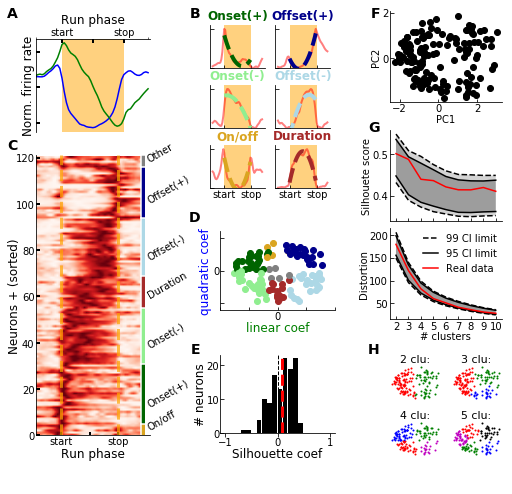

In [19]:
FIG=plt.figure(1,figsize=(cm2inch(17.6),cm2inch(16)))


if root != '/Users/davidrobbe/Documents/Data/':
    IllustrationClasses=[26,51,25,9,57,93]
else:
    IllustrationClasses=[26,25,49,9,55,91]
    


# PCA LOAD
gs1 = gridspec.GridSpec(2, 1, height_ratios=[1,3])
gs1.update(bottom=0.055,top=0.93,left=0.06,right=0.29,hspace=0.125)    


ax1=plt.subplot(gs1[0])
pca1=plot_principal_components(tuningWithBorders,2,["b","g"])
ax1.set_xlim([0,normFiringRatesAs2DArray.shape[1]])
ax1.set_xticks([nSideBin,normFiringRatesAs2DArray.shape[1]/2,normFiringRatesAs2DArray.shape[1]-nSideBin])
ax1.spines['bottom'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax1.xaxis.set_ticks_position('top')
ax1.yaxis.set_ticks_position('left')
ax1.set_xticklabels(["start","","stop"])
ax1.locator_params(axis='y',nbins=5)
ax1.axvspan(nSideBin, normFiringRatesAs2DArray.shape[1]-nSideBin, facecolor="orange",edgecolor="none",alpha=0.5)
ax1.tick_params(axis='both',which='major',width=2,direction='in',pad=1)
ax1.tick_params(labelbottom='off',labeltop='on')
ax1.xaxis.set_label_position('top')


# ax2=plt.subplot(gs2[0])
## ALL TUNING SORTED
ax2=plt.subplot(gs1[1])
plot_figureClasses(X,clu_quadraticFit,xdata,nSideBin)


    
# 6 single cell illustrations of the different classes (panel B)
gs2 = gridspec.GridSpec(3,2,hspace=0.4)
gs2.update(bottom=0.6,top=0.96,left=0.41,right=0.65)


for index,illustration in enumerate(IllustrationClasses):
    ax=plt.subplot(gs2[index])

    illustrate_classes(tuningWithoutBorder,tuningWithBorders,nSideBin,illustration,A,xdata)
    ax.yaxis.label.set_visible(False)
    ax.set_yticklabels([])
    ax.get_yaxis().set_tick_params(direction='in')

    #ax.yaxis.set_visible(False)
    if index<4:
        ax.set_xticklabels([])
    if index<6:
        ax.set_xlabel("")


# CLUSTERING based on fits
gs3 = gridspec.GridSpec(2, 1)
gs3.update(bottom=0.06,top=0.475,left=0.43,right=0.66,hspace=0.4)
ax=plt.subplot(gs3[0])
colors=["goldenrod","darkgreen","lightgreen","brown","lightblue","darkblue","gray"]
for index,clu in enumerate(tuningWithoutBorder):
    groupIndex=FindCellIndexInGroups(index,A)
    plt.plot(clu_quadraticFit[clu][1],clu_quadraticFit[clu][0],"o",color=colors[groupIndex])
    
    ax.set_xlim([-0.05,0.05])
    ax.set_ylim([-0.006,0.006])

ax.locator_params(axis='both',nbins=4)
ax.spines['top'].set_color("none")
ax.spines['right'].set_color("none")
ax.yaxis.set_ticks_position('left')
ax.set_xticklabels(["","","0"])
ax.set_yticklabels(["","","0",""])
ax.xaxis.set_ticks_position('bottom')
ax.tick_params(axis='both',direction='in',pad=1)
ax.set_ylabel("quadratic coef",fontsize=12,color='b',labelpad=1)
ax.set_xlabel("linear coef",fontsize=12,color='g',labelpad=0)
pos1 = ax.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0+0.03,  pos1.width, pos1.height]
ax.set_position(pos2)




#SIL SCORE
ax=plt.subplot(gs3[1])
allGroupLabel=[]
allCoeff=[]
for index,clu in enumerate(tuningWithoutBorder):
    groupIndex=FindCellIndexInGroups(index,A)
    if groupIndex in [0,1,2,3,4,5,6]:
        allGroupLabel.append(groupIndex)
        allCoeff.append([clu_quadraticFit[clu][1],clu_quadraticFit[clu][0]])
allGroupLabel=np.asarray(allGroupLabel)
allCoeff=np.asarray(allCoeff)
allGroupLabel.shape

silScore=metrics.silhouette_score(allCoeff,allGroupLabel)
print('Silhoute score : %f' %silScore)

silvalues=metrics.silhouette_samples(allCoeff,allGroupLabel)

plot_distribution(silvalues,[-1,1,0.1],["# neurons","Silhouette coef"])
ax.axvline(silScore,color="red",linestyle='--',linewidth=3)
ax.axvline(0,color="k",linestyle='--',linewidth=1)
ax.tick_params(axis='y',which='major',direction='in',pad=1)
ax.tick_params(axis='x',which='major',pad=1)

# Cluster analysis based on PCAc on all the cells (+ and - not )

gs4 = gridspec.GridSpec(8, 2)
gs4.update(bottom=0.05,top=0.99,left=0.77,right=0.995,hspace=0.6)
ax1=plt.subplot(gs4[0:2,0:2])


PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
ax1.scatter(PCAs[:, 0], PCAs[:, 1],color='k')
ax1.spines['top'].set_color("none")
ax1.spines['right'].set_color("none")
ax1.yaxis.set_ticks_position('left')
ax1.xaxis.set_ticks_position('bottom')
ax1.tick_params(axis='both',direction='in',pad=1)
ax1.set_xlabel('PC1',labelpad=1)
ax1.set_ylabel('PC2',labelpad=1)


ax1=plt.subplot(gs4[2:4,0:2])
ax2=plt.subplot(gs4[4:6,0:2])
savedSilScoresProfiles=testClusterQualityProfile(PCAs,nBooSstrap=5000,nbins=20,nDim=2,confidanceLimits=[[0.5,99.5],[2.5,97.5]],plotAllSurrogates=False,axesForPlot=[ax1,ax2])
ax1.set_xticklabels([""])

pos1 = ax1.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0-0.015,  pos1.width, pos1.height]
ax1.set_position(pos2)

pos1 = ax2.get_position() # get the original position 
pos2 = [pos1.x0, pos1.y0+0.015,  pos1.width, pos1.height]
ax2.set_position(pos2)



for subplotindex,numberofcluster in zip([12,13,14,15],[2,3,4,5]):
    ax=plt.subplot(gs4[subplotindex])
    kmeans=KMeans(numberofcluster,n_init=1000).fit(PCAs[:,0:2])
    plotcolorcodedclusters(kmeans.labels_,PCAs[:,0:2],markersize=1)
    ax.axis("off")
    pos1 = ax.get_position() # get the original position 
    pos2 = [pos1.x0, pos1.y0-0.04,  pos1.width, pos1.height]
    ax.set_position(pos2)
    ax.set_title('%s clu:' %(numberofcluster),fontsize=11,y=0.9)
    
    
    
#   for case,numberofcluster in enumerate(numberofclusterstotest):
#         ax=plt.subplot(gs1[case])
#         kmeans=KMeans(numberofcluster,n_init=1000).fit(allCoeff)
#         plotcolorcodedclusters(kmeans.labels_,allCoeff)
#         silScore=metrics.silhouette_score(allCoeff,kmeans.labels_)
    
    
    
figuresLabels={"A":[0.025,0.97],"C":[0.025,0.68],"B":[0.39,0.97],"D":[0.39,0.52],"E":[0.39,0.23],'F':[0.75,0.97],'G':[0.75,0.72],'H':[0.75,0.23]}
for label,coordinates in sorted(figuresLabels.items()):
    FIG.text(coordinates[0],coordinates[1],label,figure=FIG,weight='bold',fontsize=14,ha='right' ,va='bottom')


saveFullName=os.path.join(saveFigurePath,'RevisedFig03_NoClasses.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')


**Figure 3: Continuous representation of the run phases at the population level. A)**Projections of the normalized firing rate population activity onto the first 2 principal components (PC1: blue, PC2: green), computed from the tuning curves matrix shown in C. **B)** Example neurons with significant linear and positive quadratic components (onset and offset positive, top), significant linear and negative quadratic components (onset and offset negative, middle) and significant quadratic and non-significant linear components (on/off and duration, bottom). Continuous and dashed lines show the tuning curve and its corresponding fit, respectively. **C)** Tuning curves (sorted according to linear and quadratic coefficients, same colors than B) for neurons showing significant increase in firing rate. **D)** Scatter plot showing, for all positvely modulated neuron, the values of the linear and quadratic coefficients of the TTC fit (same color code than B, non classified neurons in gray). **E)** Distribution of the silhouette coefficients for data points in D. Red dashed line indicates overall silhouette score. **F)** Scatter plot of, for positively and negatively modulated neurons, the 1st and 2nd PCA values. **G)** Silhouete score (top) and distortion (bottom) when data in F are clustered in 2 to 10 clusters using a k-means algorythm.Confidence intervals (CI) are generated by randomly sampling pairs of PCA values from the inverse distribution of the real data. **H)** Data in F partitionned in 2,3,4 or 5 using k-means algorythm.


In [20]:
normFiringRatesAs2DArray.shape

(146, 52)

In [21]:
FIG=plt.figure(1,figsize=(cm2inch(17.6),cm2inch(16)))

<Figure size 692.913x629.921 with 0 Axes>

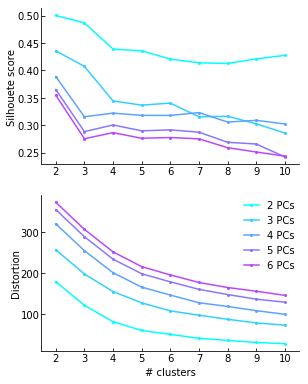

In [22]:
PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
fig, (ax1, ax2) = plt.subplots(figsize=(cm2inch(17.6/1.5),cm2inch(16)), nrows=2,sharex=True)  
colormap = plt.cm.cool
mycolors=[colormap(i) for i in np.linspace(0, 0.9, 6)]
for nDimToTest,mycolor in zip(range(2,7),mycolors):
    silScoresVsClusterNber,distorsionsVsClusterNber=clusterQualityProfile(PCAs,nDim=nDimToTest,axiswhereToPLot=[ax1,ax2],thisColor=mycolor,rangeofClusters=[2,11],legendBool=True)

saveFullName=os.path.join(saveFigurePath,'RevisedFigS03_NoClasses.pdf')
plt.savefig(saveFullName,orientation='landscape',dpi=600,format='pdf')

**Figure S3. Similar silhouette score and distortion profiles with increasing number of principal component. ** Same analysis as Fig. 3G repeated with increasing number of principal component.


# Over and done

Text(0,0.5,'PCA2')

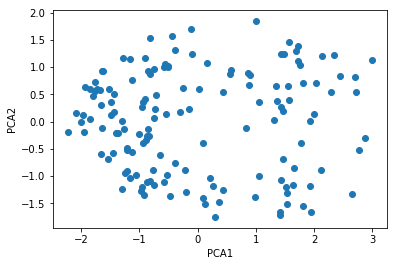

In [213]:
PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
plt.scatter(PCAs[:, 0], PCAs[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')

data exist and are loaded from pickle file


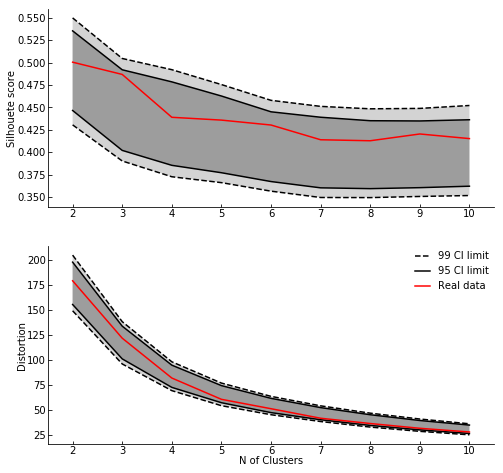

In [74]:
PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
savedSilScoresProfiles=testClusterQualityProfile(PCAs,nBooSstrap=10000,nbins=20,nDim=2,confidanceLimits=[[0.5,99.5],[2.5,97.5]],plotAllSurrogates=False)

In [ ]:
PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
savedSilScoresProfiles=testClusterQualityProfile(PCAs,nBooSstrap=1000,nbins=20,nDim=2,confidanceLimits=[[0.5,99.5],[2.5,97.5]],plotAllSurrogates=True)

In [175]:
def plotManyTypesOfClustering(numberofclusterstotest,allCoeff,numberofColumnforplot=3):  #numberofclusterstotest=[2,4,8]
    numberofsubplot=len(numberofclusterstotest)
    numberofraws=int(np.ceil(len(numberofclusterstotest)/numberofColumnforplot))
    fig=plt.figure(figsize=(15,5*numberofraws))
    gs1 = gridspec.GridSpec(numberofraws,numberofColumnforplot)
    for case,numberofcluster in enumerate(numberofclusterstotest):
        ax=plt.subplot(gs1[case])
        kmeans=KMeans(numberofcluster,n_init=1000).fit(allCoeff)
        plotcolorcodedclusters(kmeans.labels_,allCoeff)
        silScore=metrics.silhouette_score(allCoeff,kmeans.labels_)
        print('Silhoute score : %f' %silScore)
    
    

Silhoute score : 0.500375
Silhoute score : 0.489063
Silhoute score : 0.438903
Silhoute score : 0.435766


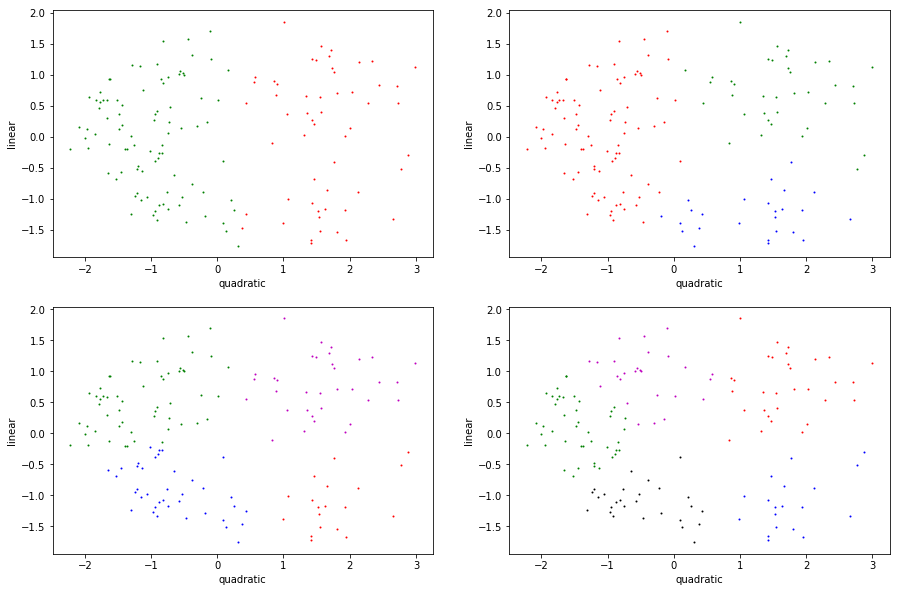

In [180]:
plotManyTypesOfClustering([2,3,4,5],PCAs[:,0:2],numberofColumnforplot=2)

In [31]:
savedSilScoresProfiles.shape

(1000, 2, 9)

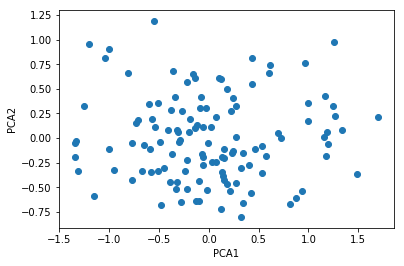

In [59]:
PCAs,tuningCurves=getPCAValues(tuningWithBorders,nDim=6)
plt.scatter(PCAs[:, 2], PCAs[:, 4])
plt.xlabel('PCA1')
plt.ylabel('PCA2')

Text(0,0.5,'PCA2')

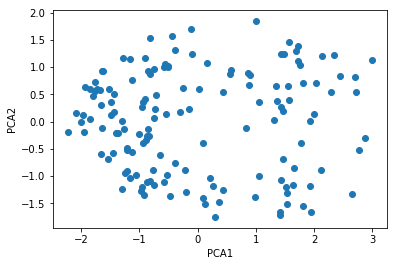

In [124]:
PCAs,tuningCurves=getPCAValues(normFiringRatesAs2DArray,nDim=6)
plt.scatter(PCAs[:, 0], PCAs[:, 1])
plt.xlabel('PCA1')
plt.ylabel('PCA2')